# Prévision de la performance énergétique des bâtiments

<br>

La performance énergétique est un enjeu majeur de la réduction de la consommation d’énergie et des émissions de gaz à effet de serre. La menace du changement climatique pèse sur l’humanité et la transition énergétique vise notamment à améliorer cette performance énergétique des bâtiments. Depuis plus d’une décennie, le diagnostic de performance énergétique vient faciliter ce travail en apportant des données clés. 

L'étude menée se distingue en 2 phases : 
 * **[Exploration statistique](#A.-Analyse-des-données)** pour comprendre les différentes variables explicatives du jeu de données et observer des éventuelles corrélations.
 * **[Modélisation](#C.-Modélisation)** des performances énergétiques de nouveaux batiments à l'aide d'algorithmes prédictifs (Random Forest, SVM, etc). Il est important de noter que nous allons traiter le problème selon 2 aspects : **[Classification](#1.-Classification)** et **[Régression](#2.-Régression)**.
 
 <br>

#### Importation des packages

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import f1_score, mean_absolute_error, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LinearRegression, Lasso
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

#### Importation des données

Téléchargement des données : http://archive.ics.uci.edu/ml/datasets/Energy+efficiency

In [31]:
input_path = 'DataEnergy.csv'
x = pd.read_csv(input_path, sep=",") 
x.head()

,Relative.compactness,Surface.area,Wall.area,Roof.area,Overall.height,orientation,Glazing.area,Glazing.area.distr,Energy,Energy.efficiency
0,0.982928,530.489958,306.484593,112.002683,7.0,North,0.016095,0,34.263943,B
1,0.983547,519.872380,299.776324,110.048028,7.0,East,-0.009387,0,34.589751,B
2,0.979453,516.191221,303.374358,106.408431,7.0,South,-0.000697,0,38.778048,C
3,0.977733,518.924089,292.812213,113.055938,7.0,West,0.000010,0,37.947808,C
4,0.903029,552.968920,316.236102,118.366409,7.0,North,-0.006592,0,47.675859,D


#### Descriptif des variables

* **Relative compactness** : compacité relative (propriété liée à la forme du batiment et sa surface).
* **Surface area** : surface totale du batiment.
* **Wall area** : surface des murs.
* **Roof area** : surface du toit.
* **Overal height** : hauteur du batiment (variable qualitative ordonnée: 3,5m et 7m).
* **Orientation** : orientation du batiment (North, East, South, West).
* **Glazing area** : surface totale des vitrages du batiment.
* **Glazing area distr** : orientation des vitrages du batiment (55% East, 55% South, etc).
* **Energy** : quantifie les performances énergétique du batiment.
* **Energy efficiency** : lettre de classification des performances énergétique du batiment.

#### Préparation des variables

In [32]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Relative.compactness  768 non-null    float64
 1   Surface.area          768 non-null    float64
 2   Wall.area             768 non-null    float64
 3   Roof.area             768 non-null    float64
 4   Overall.height        768 non-null    float64
 5   orientation           768 non-null    object 
 6   Glazing.area          768 non-null    float64
 7   Glazing.area.distr    768 non-null    int64  
 8   Energy                768 non-null    float64
 9   Energy.efficiency     768 non-null    object 
dtypes: float64(7), int64(1), object(2)
memory usage: 60.1+ KB


<br>

In [33]:
# Transformation des variables qualitatives en variables catégorielles

x['Glazing.area.distr']=x['Glazing.area.distr'].astype("category")
x['Glazing.area.distr']=x['Glazing.area.distr'].cat.rename_categories(["No glazing", "55% North", 
                                                                       "55% East", "55% South", 
                                                                       "55% West", "Uniform"])

x['orientation']=x['orientation'].astype("category")

cat_energy = CategoricalDtype(categories=["A", "B", "C", "D", "E", "F", "G"], ordered=True)
x['Energy.efficiency']=x['Energy.efficiency'].astype(cat_energy)

<br>

In [34]:
x.describe()

,Relative.compactness,Surface.area,Wall.area,Roof.area,Overall.height,Glazing.area,Energy
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764511,671.349569,318.331811,176.508879,5.25000,0.234347,46.923575
std,0.105914,88.216217,43.942031,45.206368,1.75114,0.133144,19.863003
min,0.612496,501.450033,234.338121,105.338876,3.50000,-0.024009,10.211493
25%,0.677856,598.684672,291.800051,137.385287,3.50000,0.103055,29.360416
50%,0.751687,673.069405,315.761457,183.308441,5.25000,0.247521,41.761247
75%,0.835044,744.594128,342.981089,220.510532,7.00000,0.391185,64.327196
max,0.991210,825.950839,425.805165,225.757721,7.00000,0.427021,94.842601


On remarque des valeurs négatives pour la variable Glazing Area, qui représente pourtant la surface totale des vitrages. En fait, ces valeurs négatives sont dues à un bruit ajouté. Regardons comment sont réparties ces valeurs négatives afin de leur appliquer une correction.

<br>

In [35]:
x[x['Glazing.area']<0]['Glazing.area.distr'].value_counts(normalize = False)

No glazing    24
Uniform        0
55% West       0
55% South      0
55% East       0
55% North      0
Name: Glazing.area.distr, dtype: int64

<br>

D'après le resultat ci-dessus, toutes les valeurs de Glazing.area inférieures à 0 appartiennent à la catégorie **No glazing**. On va donc forcer leur valeur à 0.

In [36]:
x['Glazing.area'][x['Glazing.area'] < 0] = 0

/Users/cecile/opt/anaconda3/envs/ApprentissageML/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<br>

On remarque aussi que la variable **Overall.height** prend seulement deux niveaux ordonnés : 3,5m et 7m. On va donc considérer cette variable comme catégorielle ordonnée.

In [37]:
cat_overall = CategoricalDtype(categories=[3.5, 7], ordered=True)
x['Overall.height'] = x['Overall.height'].astype(cat_overall)

In [38]:
category_orders={'Energy.efficiency': ["A", "B", "C", "D", "E", "F", "G"], 
                 'Overall.heigth':[3.5, 7]}

<br>

## A. Analyse des données


### 1. Statistiques descriptives univariées

<br>

In [39]:
px.histogram(x, x="Energy.efficiency", category_orders=category_orders, 
            title="Proportion du nombre de batiments par classe énergétique", 
            width=800, height=400)

La répartition des données par classe énergie est plutot uniforme. On observe cependant  que la classe A est majoritaire dans ce jeu de données.

<br>

In [40]:
px.box(pd.melt(x[['Relative.compactness', 'Surface.area', 'Wall.area', 'Roof.area', 
                  'Glazing.area', 'Energy']]), x="variable", y="value", points="outliers", 
      width=800, height=400, title="Box plot des variables quantitatives")

Les variables ne sont pas toutes de même ordre de grandeur mais les distributions semblent homogènes. Etant donné les ordres de grandeurs bien différents, une attention particulière sera accordée lors de la réalisation de l'ACP. \
Il faut maintenant étudier plus précisemment la distribution de ces variables.

<br>

In [41]:
# Quels bins choisir ?
fig = make_subplots(rows=2, cols=3, subplot_titles=("Glazing area distribution", 
                                                    "Relative compactness distribution", 
                                                    "Roof area distribution", 
                                                    "Surface area distribution",
                                                    "Wall area distribution",
                                                    "Energy distribution"))


fig.append_trace(go.Histogram(x=x["Glazing.area"]), 1, 1)
fig.append_trace(go.Histogram(x=x["Relative.compactness"]), 1, 2)
fig.append_trace(go.Histogram(x=x["Roof.area"]), 1, 3)
fig.append_trace(go.Histogram(x=x["Surface.area"]), 2, 1)
fig.append_trace(go.Histogram(x=x["Wall.area"]), 2, 2)
fig.append_trace(go.Histogram(x=x["Energy"]), 2, 3)

fig.update_layout(showlegend=False, title_text="Distribution des variables quantitatives")
fig.show()

Il n'y a pas de transformation de variables nécessaires. On remarque tout de même que la variable **Roof Area** est inéquitablement répartie.

<br>

In [42]:
px.pie(x, names='orientation', width=500, height=400, 
       title="Proportion du nombre de batiment selon l'orientation")

La répartition des orientations des bâtiments est totalement uniforme pour le jeu de données.

<br>

In [43]:
px.histogram(x, x="Glazing.area.distr", 
             title="Proportion du nombre de batiments par orientation des vitrages", 
             width=800, height=400)

La répartition des orientations des vitrages est équitable entre les différentes classes (55% Nord, 55% Est, 55% Sud, 55% Ouest et sans vitrage). Cependant, les batiments sans vitres sont minoritaires.

<br>

### 2. Statistiques descriptives multivariées

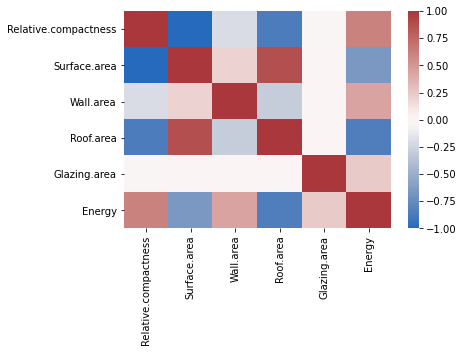

In [44]:
# tourner axe des x + title

corrMatrix = x.corr()

sns.heatmap(corrMatrix, cmap="vlag", vmin=-1, vmax=1);

   * **Relative compactness** est très fortement correlé négativement avec Surface area (-0.98) et Roof Area (-0.87). Il doit exister un lien numérique entre ces variables que nous étudierons par la suite.

   * **Roof Area** est aussi fortement corrélé avec Energy.
    
Il est difficile de tirer des conclusions avec le graphique des corrélations. Regardons la matrice de scatterplots.

<br>

In [45]:
# A retourner en y !

px.scatter_matrix(x, dimensions=['Relative.compactness', 'Surface.area', 'Wall.area', 
                                 'Roof.area', 'Glazing.area', 'Energy'], 
                 title="Matrixplot ")

<br>

On remarque une **relation linéaire entre Relative.compactness et Surface.area.** \
On voit que **Glazing.area**, qui est une variable quantitative, est finalement **répartie selon 4 intervalles.**

<br>

In [46]:
## On vérifie la relation Surface.area = Wall.area + 2*Roof.area

a=list(x['Surface.area']-(x['Wall.area']+2*x['Roof.area']))

c=0
for i in range(len(a)):
    if round(a[i], 3) != 0:
        c+=1

print("Nombre de valeurs pour lesquelles la relation \"Surface.area = Wall.area + 2*Roof.area \" n\'est pas vérifiée : ", c)

Nombre de valeurs pour lesquelles la relation "Surface.area = Wall.area + 2*Roof.area " n'est pas vérifiée :  0


<br>
La surface est calculée en sommant la surface des murs et en ajoutant deux fois la surface du toit. \
La relation étant vérifiée pour tous les points de notre jeu de donnée, nous allons pouvoir supprimer une ou plusieurs variables étant donné que les informations sont redondantes.

<br>

In [47]:
fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=['Surface des murs', 'Surface du toit', 'Surface totale'])

fig.append_trace(go.Box(x=x["Energy.efficiency"], y=x["Wall.area"]), 1, 1)
fig.append_trace(go.Box(x=x["Energy.efficiency"], y=x["Roof.area"]), 1, 2)
fig.append_trace(go.Box(x=x["Energy.efficiency"], y=x["Surface.area"]), 1, 3)

fig.update_layout(showlegend=False, 
                  title_text="Distribution en fonction de la classe énergétique")

fig.update_xaxes(categoryorder='array', categoryarray=category_orders['Energy.efficiency'])

fig.show()

On remarque sur ces graphiques que les classes A, B et C ont une surface de toît élevée. De la même façon, ces classes ont une surface totale élevée. \
La tendance est inversée pour les classes D, E, F et G.

Pour continuer l'analyse, on va donc supprimer la variable **Roof Area**, d'une part car son information est contenue dans la variable **Surface Area** et d'autre part car sa distribution est inéquitablement répartie.

**On retire donc la variable Roof Area.**

In [48]:
x = x.drop("Roof.area", axis=1)

<br>

In [49]:
px.box(x, x="Energy.efficiency", y="Overall.height", 
       title='Hauteur du batiment en fonction de la classe énergétique', 
       width=800, height=400)

On remarque sur le graphique de gauche que les classes A, B et C ont majoritairement une hauteur de 3m50 tandis que les classes D, E, F et G ont principalement une hauteur plus élevé (7m).

<br>

In [50]:
### Stop je saute jusqu'à modélisation

In [51]:
fig = px.box(x, x="Energy.efficiency", y="Relative.compactness", 
            title='Relative compactness en fonction de la classe énergétique')
fig.show()

De la même façon, on remarque que la Relative Compactness est plus faible pour les bonnes classes énergetiques par rapport aux moins bonnes.

In [52]:
fig = px.histogram(x, x="Energy.efficiency", color="orientation", barmode='group', 
                  title='Répartition de l\'orientation du batiment en fonction des classes énergétiques')
fig.show()

In [53]:
fig = px.histogram(x, x="Energy.efficiency", color="Glazing.area.distr", barmode='group', 
                   title='')
fig.show()

Les classes d'énergie sont uniformement réparties selon l'orientation du bâtiment et selon l'orientation des vitrages. L'orientation des bâtiments n'influe donc probablement pas l'appartenance à une certaine classe d'énergie.

En revanche, lorsqu'il y a pas de vitrage ou lorsque l'orientation des vitrages est uniforme, la classe A est majoritaire. (Logique, un batiment sans vitrage est mieux isolé)

<br>

### 3. Analyse en Composantes Principales

On enlève la variable Energy car c'est celle que l'on veut prédire. On garde seulement les variables quantitatives pour faire l'ACP.

**Remarque :** Les variables n'étant pas dans les mêmes unités, nous faisons une ACP centrée réduite.

<br>

In [133]:
scaler = StandardScaler()
scaler.fit(x[['Relative.compactness', 'Surface.area', 'Wall.area', 'Glazing.area']])
X_scaler = scaler.transform(x[['Relative.compactness', 'Surface.area', 'Wall.area', 'Glazing.area']])

pca = PCA()
pca.fit_transform(X_scaler);
#pq Energy.efficiency dans le R vu que c'est la variable réponse ?

In [134]:
fig = go.Figure(data=[go.Bar(x=['dim1', 'dim2', 'dim3', 'dim4'],
                             y=pca.explained_variance_ratio_*100)])
fig.update_layout(title_text='Pourcentage de variance expliquée par dimension')

fig.update_xaxes(title_text = "Dimensions")
fig.update_yaxes(title_text = "% variance")

Au vu du pourcentage de variance expliqué et des ditributions des trois premières dimensions, nous sommes tentés de les garder.

<br>

In [135]:
sqrt_eigval = np.sqrt(pca.singular_values_)

corvar = np.zeros((4,4))

for k in range(4):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]

In [136]:
corvar ##mm vu les vlaeurs y a un soucis

array([[ 4.31272232e+00,  2.18680280e-03,  9.30130694e-01,
         1.22829669e+00],
       [-4.31051289e+00,  1.08146354e-02, -9.45350000e-01,
         1.22756433e+00],
       [-1.62070689e+00,  2.06484533e-02,  4.98924085e+00,
         3.59706290e-03],
       [-1.34208555e-02, -5.26424287e+00,  1.80140822e-02,
         3.04620768e-03]])

In [137]:
X = x[['Relative.compactness', 'Surface.area', 'Wall.area', 'Glazing.area']]

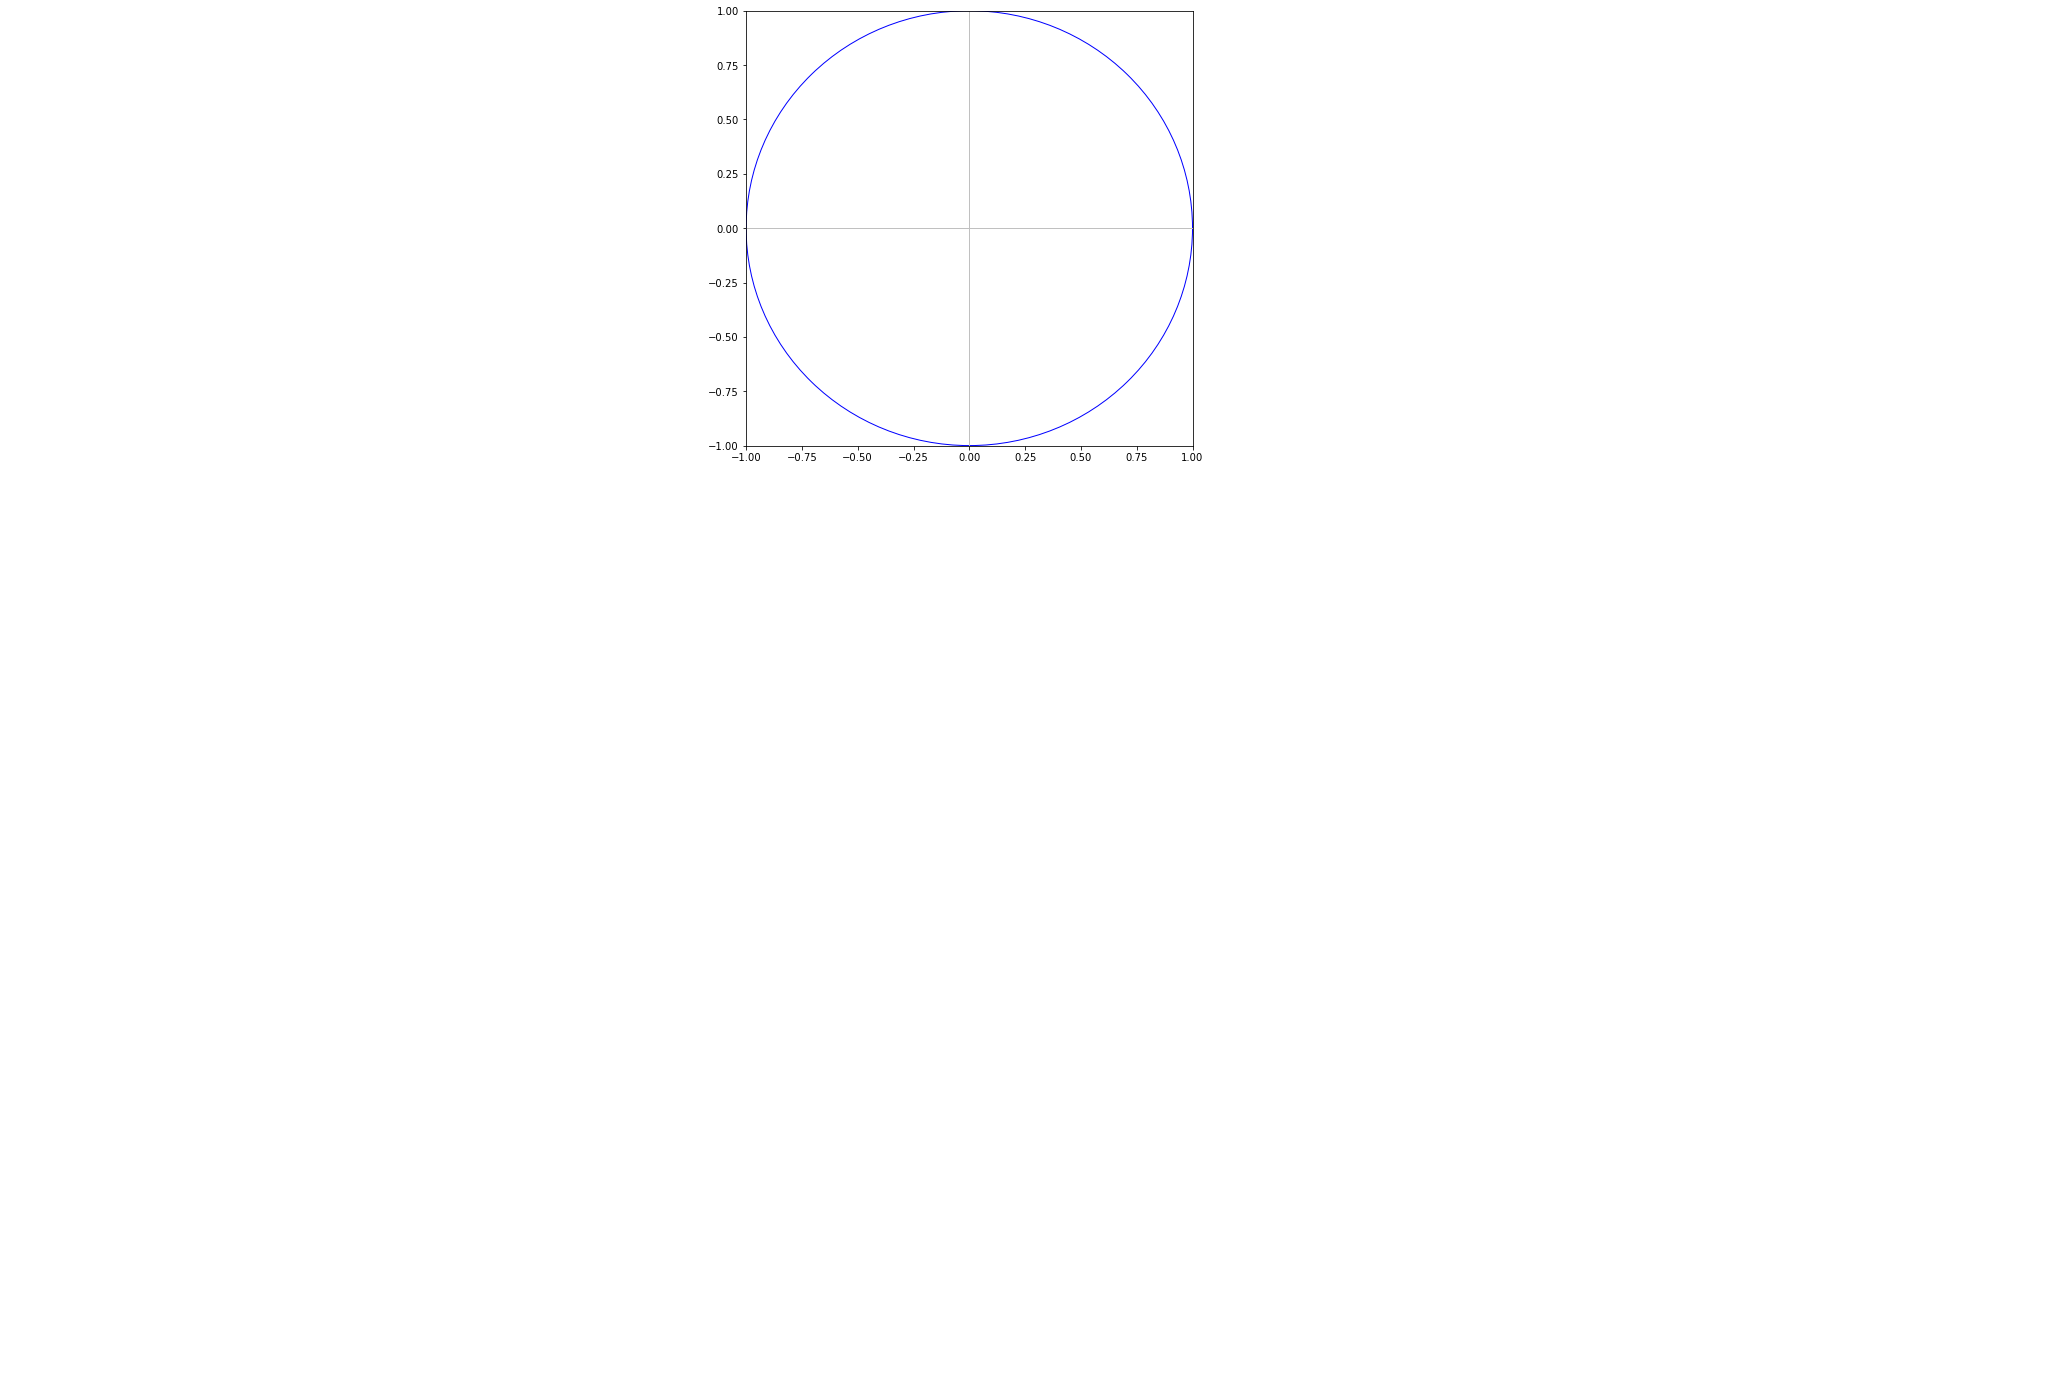

In [138]:
fig, axes = plt.subplots(figsize=(8,8)) 
axes.set_xlim(-1,1) 
axes.set_ylim(-1,1)
#affichage des étiquettes (noms des variables)
for j in range(4): 
    plt.annotate(X.columns[j],(corvar[j,0],corvar[j,1]))
#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1) 
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False) 
axes.add_artist(cercle)
#affichage
plt.show()

<br>

### 4. Clustering

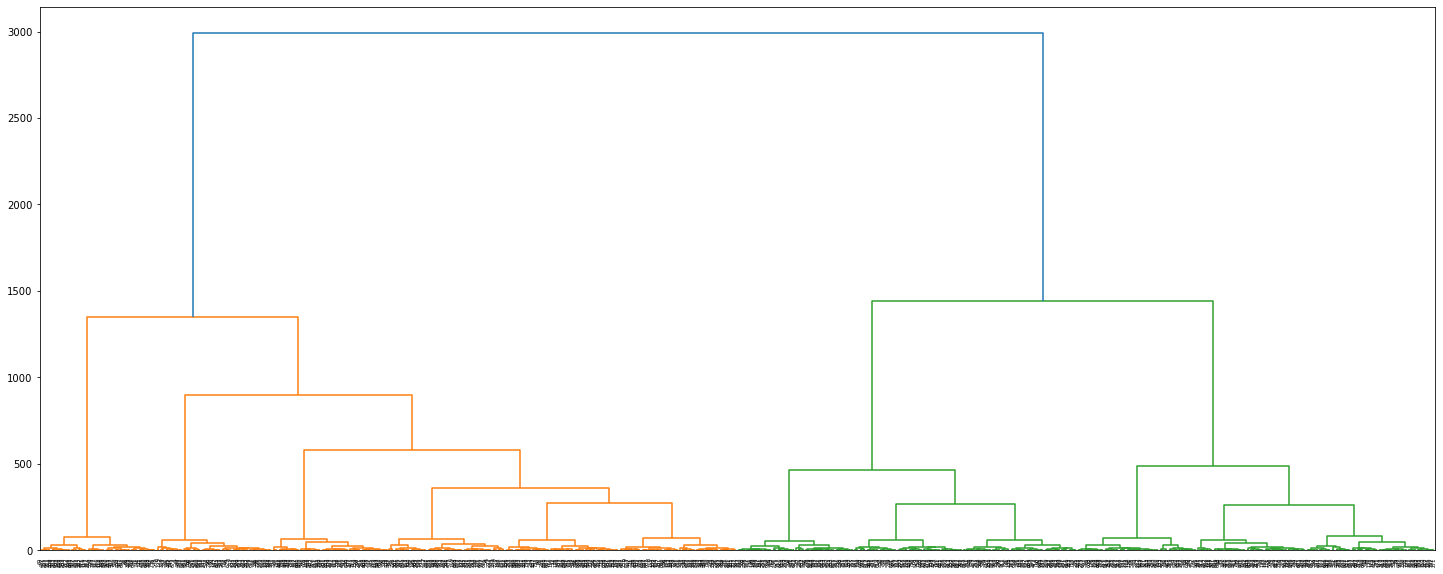

In [141]:
X = pdist(x[['Relative.compactness', 'Surface.area', 'Wall.area', 'Glazing.area']])
Z = linkage(X, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [143]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(x[['Relative.compactness', 'Surface.area', 'Wall.area', 'Glazing.area']])
    distortions.append(kmeanModel.inertia_)

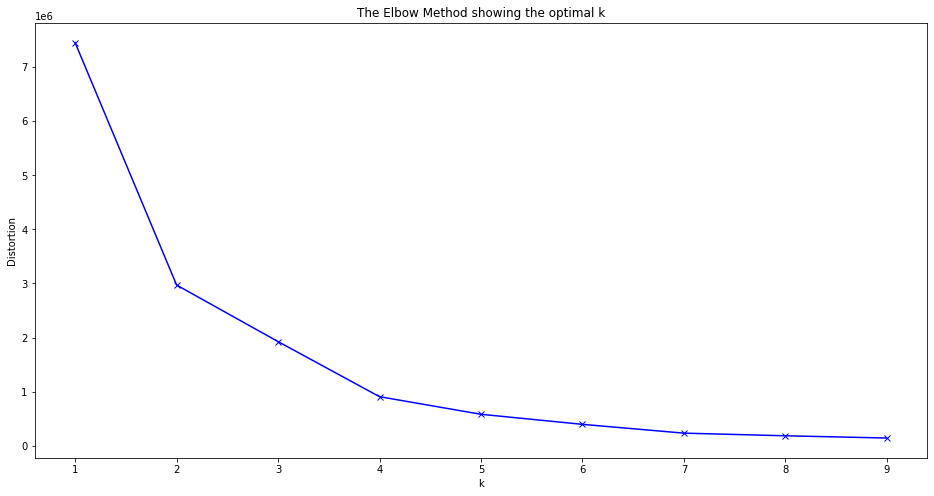

In [144]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<br>


Ces deux méthodes nous suggèrent 2 clusters, or on aimerait qu'il y en ai 7 (correspondant aux 7 classes énergétiques)

<br>

## B. Séparation des données

On sépare les données en un ensemble d'apprentissage (train) et un ensemble test. Le modèle est entrainé sur l'échantillon train et il est évalué sur l'échantillon test.

Cette étape est nécessaire pour permettre d'évaluer le modèle déterminé avec les échantillons d'entrainement. En effet, on peut par exemple détecter un overfitting grâce à l'échantillon test (un très bon score avec l'échantillon d'entrainement ne signifie pas toujours que c'est un très bon modèle).

In [25]:
# suppression variables réponses
X = x.drop(['Energy', 'Energy.efficiency'], axis=1)

# suppression variables qualitatives
X = X.drop(['Overall.height', 'orientation', 'Glazing.area.distr'], axis=1)

# transformation variables qualitatives en indicatrices
X_quali = pd.get_dummies(x[['Overall.height', 'orientation', 'Glazing.area.distr']])

# une seule indicatrice pour une variable binaire
X_quali = X_quali.drop(["Overall.height_7.0"], axis=1) 

# concat variables quali & quanti
X = pd.concat([X, X_quali], axis=1)


y = x[['Energy', 'Energy.efficiency']]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=10)

In [27]:
def metrics(y_test, y_pred, res, method):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    #mae = mean_absolute_error(y_test, y_pred)
    res[method] = [accuracy, f1]
    return pd.DataFrame.from_dict(res, orient='index', columns=['accuracy', 'macro f1'])

<br>

## C. Modélisation

## 1. Classification

Dans cette partie, nous nous concentrons uniquement sur le problème de classification, qui consiste à **prédire la classe énergétique d'un batiment**. La variable quantitative Energy est donc supprimée de cette partie.

In [28]:
# variable recensant tous les résultats des modèles
res_class = {}

# variable explicative qualitative
y_train_class = y_train['Energy.efficiency']
y_test_class = y_test['Energy.efficiency']

### a. Régression logistique polythomiale

In [29]:
lr = LogisticRegression(multi_class='ovr', max_iter=1000) #multi_class='ovr' oui ou non ?
mlr = lr.fit(X_train, y_train_class)

y_pred = mlr.predict(X_test)

In [30]:
metrics(y_test_class, y_pred, res_class, 'lr multiclass')

,accuracy,macro f1
lr multiclass,0.532468,0.418833


In [31]:
# A faire plus joli si le temps le permet !
confusion_matrix(y_test_class, y_pred)

array([[42,  2,  2,  0,  0,  0,  0],
       [13,  4,  4,  1,  0,  0,  0],
       [ 4,  4,  4,  0,  0,  0,  0],
       [ 0,  0,  0,  2, 11,  4,  2],
       [ 0,  0,  0,  1, 19,  4,  1],
       [ 0,  0,  0,  1,  8,  5,  4],
       [ 0,  0,  0,  0,  1,  5,  6]])

### b. Régression logistique pénalisée

In [32]:
mridge = RidgeClassifier().fit(X_train, y_train_class) 

y_pred = mridge.predict(X_test)

In [33]:
metrics(y_test_class, y_pred, res_class, 'ridge')

,accuracy,macro f1
lr multiclass,0.532468,0.418833
ridge,0.525974,0.390903


In [34]:
confusion_matrix(y_test_class, y_pred)

array([[45,  1,  0,  0,  0,  0,  0],
       [19,  2,  0,  1,  0,  0,  0],
       [ 9,  2,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  3, 10,  3,  3],
       [ 0,  0,  0,  1, 15,  6,  3],
       [ 0,  0,  0,  1,  6,  7,  4],
       [ 0,  0,  0,  0,  1,  3,  8]])

### c. Arbre de décision

In [35]:
tree = DecisionTreeClassifier()
mtree = tree.fit(X_train, y_train_class) 

y_pred = mtree.predict(X_test)

In [36]:
metrics(y_test_class, y_pred, res_class, 'tree')

,accuracy,macro f1
lr multiclass,0.532468,0.418833
ridge,0.525974,0.390903
tree,0.603896,0.565573


In [37]:
# a faire plus joli ?
confusion_matrix(y_test_class, y_pred)

array([[37,  9,  0,  0,  0,  0,  0],
       [ 7, 10,  4,  1,  0,  0,  0],
       [ 2,  3,  7,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  6,  1,  0],
       [ 0,  0,  0,  2, 13, 10,  0],
       [ 0,  0,  0,  0,  3,  9,  6],
       [ 0,  0,  0,  0,  1,  6,  5]])

<br>

Déterminons maintenant le meilleur paramètre de complexité (cp) pour élager l'arbre et obtenir un meilleur taux de classification.

In [38]:
param = [{"max_depth":list(range(2,10))}]
mtree = GridSearchCV(DecisionTreeClassifier(), param, cv=5, n_jobs=-1)
mopt = mtree.fit(X_train, y_train_class)

# paramètre optimal
mopt.best_params_

{'max_depth': 6}

In [39]:
tree_elag = DecisionTreeClassifier(max_depth=mopt.best_params_['max_depth'])
mtree_elag = tree_elag.fit(X_train, y_train_class)

y_pred = mtree_elag.predict(X_test)

In [40]:
res = metrics(y_test_class, y_pred, res_class, 'optimal tree')
res.head()

,accuracy,macro f1
lr multiclass,0.532468,0.418833
ridge,0.525974,0.390903
tree,0.603896,0.565573
optimal tree,0.597403,0.556244


In [41]:
confusion_matrix(y_test_class, y_pred)

array([[38,  7,  1,  0,  0,  0,  0],
       [15,  6,  1,  0,  0,  0,  0],
       [ 2,  4,  6,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  7,  0,  0],
       [ 0,  0,  0,  2, 13, 10,  0],
       [ 0,  0,  0,  0,  2, 13,  3],
       [ 0,  0,  0,  0,  3,  5,  4]])

In [42]:
# Afficher l'arbre !

### d. Random Forest

In [43]:
forest = RandomForestClassifier(max_features="sqrt")
mforest = forest.fit(X_train, y_train_class)

y_pred = mforest.predict(X_test)

In [44]:
metrics(y_test_class, y_pred, res_class, 'random forest')

,accuracy,macro f1
lr multiclass,0.532468,0.418833
ridge,0.525974,0.390903
tree,0.603896,0.565573
optimal tree,0.597403,0.556244
random forest,0.616883,0.576021


In [45]:
confusion_matrix(y_test_class, y_pred)

array([[41,  5,  0,  0,  0,  0,  0],
       [11,  7,  3,  1,  0,  0,  0],
       [ 4,  2,  6,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  9,  1,  0],
       [ 0,  0,  0,  1, 13, 10,  1],
       [ 0,  0,  0,  0,  4, 12,  2],
       [ 0,  0,  0,  0,  0,  5,  7]])

In [46]:
# a voir sur quels params jouer pour optimiser ???

#param = [{"n_estimators":list(range(5,15))}]
#mforest = GridSearchCV(RandomForestClassifier(), param, cv=5, n_jobs=-1)
#mopt = mforest.fit(X_train, y_train_class)

# paramètre optimal
#mopt.best_params_

In [47]:
#forest_opt = RandomForestClassifier(max_features="sqrt", 
#                                    n_estimators=mopt.best_params_['n_estimators'])
#mforest_opt = forest_opt.fit(X_train, y_train_class)

#y_pred = mforest_opt.predict(X_test)

In [48]:
#res = metrics(y_test_class, y_pred, resultats, 'random forest opt')
#res.head()

### e. Boosting

In [49]:
gboost = GradientBoostingClassifier().fit(X_train, y_train_class)

y_pred = gboost.predict(X_test)

In [50]:
metrics(y_test_class, y_pred, res_class, 'gradient boosting')

,accuracy,macro f1
lr multiclass,0.532468,0.418833
ridge,0.525974,0.390903
tree,0.603896,0.565573
optimal tree,0.597403,0.556244
random forest,0.616883,0.576021
gradient boosting,0.584416,0.533397


In [51]:
confusion_matrix(y_test_class, y_pred)

array([[39,  6,  1,  0,  0,  0,  0],
       [12,  5,  4,  1,  0,  0,  0],
       [ 2,  6,  4,  0,  0,  0,  0],
       [ 0,  0,  1, 11,  7,  0,  0],
       [ 0,  0,  0,  4, 13,  8,  0],
       [ 0,  0,  0,  0,  4, 10,  4],
       [ 0,  0,  0,  0,  0,  4,  8]])

In [52]:
# Trop long ! a voir comment jouer sur les params ?

#param = [{"learning_rate":np.linspace(0,0.1,5), 'n_estimators':list(range(90,110))}]
#mgboost = GridSearchCV(GradientBoostingClassifier(), param, cv=5, n_jobs=-1)
#mopt = mgboost.fit(X_train, y_train_class)

# paramètre optimal
#mopt.best_params_

In [53]:
#gboost_opt = GradientBoostingClassifier(learning_rate=mopt.best_params_['learning_rate'], 
#                                       n_estimators=mopt.best_params_['n_estimators']).fit(X_train, y_train_class)

#gboost_opt.score(X_test, y_test_class) 

### f. SVM

In [54]:
svm_c = svm.SVC(decision_function_shape='ovo')
msvm_c = svm_c.fit(X_train, y_train_class)

y_pred = msvm_c.predict(X_test)

In [55]:
metrics(y_test_class, y_pred, res_class, 'SVM')

,accuracy,macro f1
lr multiclass,0.532468,0.418833
ridge,0.525974,0.390903
tree,0.603896,0.565573
optimal tree,0.597403,0.556244
random forest,0.616883,0.576021
gradient boosting,0.584416,0.533397
SVM,0.487013,0.244301


In [56]:
confusion_matrix(y_test_class, y_pred)

array([[46,  0,  0,  0,  0,  0,  0],
       [21,  0,  0,  0,  1,  0,  0],
       [12,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 19,  0,  0],
       [ 0,  0,  0,  0, 24,  0,  1],
       [ 0,  0,  0,  0, 13,  0,  5],
       [ 0,  0,  0,  0,  7,  0,  5]])

### Bilan classification

<br>


## 2. Régression

Nous étudions maintenant le problème de régression, qui consiste à **prédire la valeur numérique de l'efficacité énergétique d'un batiment**. La variable qualitative Energy.efficiency est donc supprimée de cette partie.

In [57]:
# variable recensant tous les résultats des modèles
res_reg = {}

# variable explicative quantitative
y_train_reg = y_train['Energy']
y_test_reg = y_test['Energy.efficiency']

In [58]:
# permet de trouver la classe energetique à partir de la valeur numérique prédite

def classify(value):
    if value <= 30 : return 'A'
    elif value > 30 and value <= 35 : return 'B'
    elif value > 35 and value <= 45 : return 'C'
    elif value > 45 and value <= 55 : return 'D'
    elif value > 55 and value <= 65 : return 'E'
    elif value > 65 and value <= 75 : return 'F'
    elif value > 75 : return 'G'
    
def pred_classifiy(y_pred):
    tab = []
    for v in y_pred:
        tab += classify(v)
    return tab

### a. Régression linéaire

In [59]:
lr = LinearRegression()
mlr = lr.fit(X_train, y_train_reg)

y_pred_reg = mlr.predict(X_test) # prediction à valeurs continues
y_pred = pred_classifiy(y_pred_reg) # equivalence avec la classe énergétique

In [60]:
metrics(y_test_reg, y_pred, res_reg, 'regression lin')

,accuracy,macro f1
regression lin,0.584416,0.530402


In [61]:
confusion_matrix(y_test_reg, y_pred)

array([[33,  9,  4,  0,  0,  0,  0],
       [ 3, 12,  6,  1,  0,  0,  0],
       [ 2,  3,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  9,  5,  0],
       [ 0,  0,  0,  1, 19,  5,  0],
       [ 0,  0,  0,  0,  7, 10,  1],
       [ 0,  0,  0,  0,  1,  7,  4]])

<br>

### b. Régression linéaire pénalisée

In [62]:
lasso = Lasso()
mlasso = lasso.fit(X_train, y_train_reg)

y_pred_reg = mlasso.predict(X_test) 
y_pred = pred_classifiy(y_pred_reg)

In [63]:
metrics(y_test_reg, y_pred, res_reg, 'lasso')

,accuracy,macro f1
regression lin,0.584416,0.530402
lasso,0.357143,0.317988


In [64]:
confusion_matrix(y_test_reg, y_pred)

array([[21, 14, 11,  0,  0,  0,  0],
       [ 7,  9,  5,  0,  1,  0,  0],
       [ 2,  4,  6,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 10,  8,  0],
       [ 0,  0,  0,  1,  8, 16,  0],
       [ 0,  0,  0,  2,  4,  7,  5],
       [ 0,  0,  0,  0,  5,  4,  3]])

### c. Arbre de décision

In [65]:
tree = DecisionTreeRegressor()
mtree = tree.fit(X_train, y_train_reg) 

y_pred_reg = mtree.predict(X_test) 
y_pred = pred_classifiy(y_pred_reg)

In [66]:
metrics(y_test_reg, y_pred, res_reg, 'tree')

,accuracy,macro f1
regression lin,0.584416,0.530402
lasso,0.357143,0.317988
tree,0.590909,0.550693


In [67]:
confusion_matrix(y_test_reg, y_pred)

array([[37,  6,  3,  0,  0,  0,  0],
       [11,  8,  3,  0,  0,  0,  0],
       [ 3,  1,  8,  0,  0,  0,  0],
       [ 0,  0,  2,  9,  7,  1,  0],
       [ 0,  0,  1,  2, 13,  7,  2],
       [ 0,  0,  0,  0,  4, 10,  4],
       [ 0,  0,  0,  0,  1,  5,  6]])

In [68]:
## il faut elaguer l'arbre

### d. Random Forest

In [69]:
forest = RandomForestRegressor()
mforest = forest.fit(X_train, y_train_reg)

y_pred_reg = mforest.predict(X_test) 
y_pred = pred_classifiy(y_pred_reg)

In [70]:
metrics(y_test_reg, y_pred, res_reg, 'random forest')

,accuracy,macro f1
regression lin,0.584416,0.530402
lasso,0.357143,0.317988
tree,0.590909,0.550693
random forest,0.662338,0.630376


In [71]:
confusion_matrix(y_test_reg, y_pred)

array([[39,  7,  0,  0,  0,  0,  0],
       [ 7, 12,  3,  0,  0,  0,  0],
       [ 2,  5,  5,  0,  0,  0,  0],
       [ 0,  0,  0, 11,  8,  0,  0],
       [ 0,  0,  0,  1, 14,  9,  1],
       [ 0,  0,  0,  0,  3, 12,  3],
       [ 0,  0,  0,  0,  0,  3,  9]])

### e. Boosting

In [72]:
gboost = GradientBoostingRegressor().fit(X_train, y_train_reg) 

y_pred_reg = gboost.predict(X_test) 
y_pred = pred_classifiy(y_pred_reg)

In [73]:
metrics(y_test_reg, y_pred, res_reg, 'boosting')

,accuracy,macro f1
regression lin,0.584416,0.530402
lasso,0.357143,0.317988
tree,0.590909,0.550693
random forest,0.662338,0.630376
boosting,0.675325,0.647076


In [74]:
confusion_matrix(y_test_reg, y_pred)

array([[39,  7,  0,  0,  0,  0,  0],
       [ 8, 11,  3,  0,  0,  0,  0],
       [ 2,  5,  5,  0,  0,  0,  0],
       [ 0,  0,  0, 13,  6,  0,  0],
       [ 0,  0,  0,  1, 14, 10,  0],
       [ 0,  0,  0,  0,  2, 14,  2],
       [ 0,  0,  0,  0,  0,  4,  8]])

### f. SVM

In [75]:
svm_r = svm.SVR()
msvm_r = svm_r.fit(X_train, y_train_reg)

y_pred_reg = svm_r.predict(X_test) 
y_pred = pred_classifiy(y_pred_reg)

In [76]:
metrics(y_test_reg, y_pred, res_reg, 'SVM')

,accuracy,macro f1
regression lin,0.584416,0.530402
lasso,0.357143,0.317988
tree,0.590909,0.550693
random forest,0.662338,0.630376
boosting,0.675325,0.647076
SVM,0.344156,0.280653


In [77]:
confusion_matrix(y_test_reg, y_pred)

array([[ 6, 24, 16,  0,  0,  0,  0],
       [ 0,  9, 12,  1,  0,  0,  0],
       [ 0,  2, 10,  0,  0,  0,  0],
       [ 0,  0,  0, 11,  8,  0,  0],
       [ 0,  0,  0,  9, 16,  0,  0],
       [ 0,  0,  0,  4, 13,  1,  0],
       [ 0,  0,  0,  5,  7,  0,  0]])

### Bilan régression